# Catboost

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import tqdm

import lightgbm as lgb
import xgboost as xgb

from catboost import Pool, CatBoostClassifier, CatBoostRanker, cv
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Данные

In [4]:
df = pd.read_parquet('/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Подготовленные_данные/all_data.parquet', 
                  index=False, engine='fastparquet')

In [5]:
df.head()

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,fclose_flag_1,pre_loans5_11,pre_loans3060_6,pre_since_confirmed_15,pre_loans3060_4,pre_loans6090_0,pre_loans3060_3,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0,flag
0,0,0,1,1,1,1,2,0,1,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,1,0,0,0,0,1,2,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,1,0,0,0,0,0,0,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0,3,1,0,2,1,3,0,0,...,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0,0,0,0,0,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
X = df.drop('flag', axis=1)
y = df['flag']

In [7]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 2893558, One count = 106442


Text(0.5, 0, 'y')

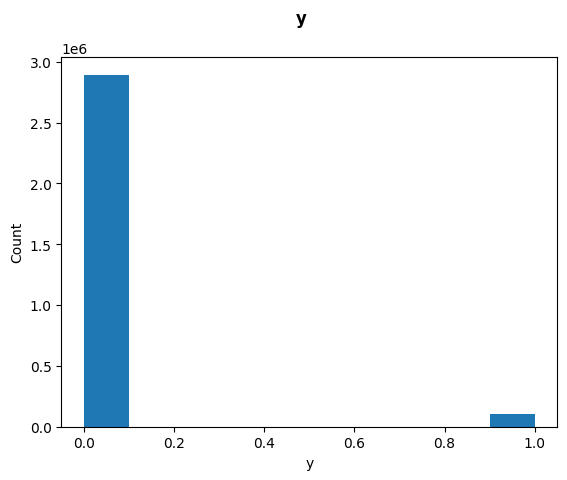

In [8]:
plt.hist(y)  # density=False would make counts
plt.suptitle('y', fontweight='bold')
plt.ylabel('Count')
plt.xlabel('y')

Разделим выборку на test и train

In [10]:
def split(data):
    X = data.drop('flag', axis=1)
    y = data['flag']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = split(df)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100000, 420), (900000, 420), (2100000,), (900000,))

# Catboost Classifier

Параметры модели:

1. iterations - кол-во деревьев в ансамбле
2. learning_rate - шаг обучения (с какой скоростью обучаемся) 
3. loss_function-  функция потерь
4. verbose - через какой шаг показываем информацию 
5. auto_class_weights - устраняет дисбаланс автоматически
6. early_stopping_rounds - устанавливает количество итераций для останова, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной
7. eval_metric - метрика
8. depth - глубина дерева
9. task_type

## Baseline

In [13]:
model_catboost = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1, 
    custom_metric=['AUC','Accuracy'], 
    eval_metric = 'AUC',
#     early_stopping_rounds=5,    
    depth=5,
    random_state=42,
    verbose=1
)

In [14]:
model_catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=False
)
print('Model is fitted: ' + str(model_catboost.is_fitted()))
print('Model params: ')
print(model_catboost.get_params())

0:	test: 0.5120687	best: 0.5120687 (0)	total: 486ms	remaining: 4.38s
1:	test: 0.5716124	best: 0.5716124 (1)	total: 947ms	remaining: 3.79s
2:	test: 0.6070466	best: 0.6070466 (2)	total: 1.45s	remaining: 3.37s
3:	test: 0.6073597	best: 0.6073597 (3)	total: 1.99s	remaining: 2.98s
4:	test: 0.6155927	best: 0.6155927 (4)	total: 2.48s	remaining: 2.48s
5:	test: 0.6348544	best: 0.6348544 (5)	total: 2.88s	remaining: 1.92s
6:	test: 0.6631946	best: 0.6631946 (6)	total: 3.44s	remaining: 1.48s
7:	test: 0.6814427	best: 0.6814427 (7)	total: 4.03s	remaining: 1.01s
8:	test: 0.6951771	best: 0.6951771 (8)	total: 4.65s	remaining: 516ms
9:	test: 0.7014084	best: 0.7014084 (9)	total: 5.28s	remaining: 0us

bestTest = 0.7014083573
bestIteration = 9

Model is fitted: True
Model params: 
{'iterations': 10, 'learning_rate': 0.1, 'depth': 5, 'verbose': 1, 'custom_metric': ['AUC', 'Accuracy'], 'eval_metric': 'AUC', 'random_state': 42}


In [15]:
print("Best Score: \n", model_catboost.get_best_score())

Best Score: 
 {'learn': {'Accuracy': 0.9645452380952381, 'Logloss': 0.18079549870279038}, 'validation': {'Accuracy': 0.9644622222222222, 'Logloss': 0.18098013152511094, 'AUC': 0.7014083573369208}}


In [2]:
# model_catboost.get_evals_result()

**Метрика AUC**

In [24]:
df_score_cat_auc = pd.DataFrame()

df_score_cat_auc['iter'] = [i for i in range(0, len(model_catboost.get_evals_result()['validation']['AUC']))]
df_score_cat_auc['score'] = model_catboost.get_evals_result()['validation']['AUC']

In [25]:
df_score_cat_auc.head()

,iter,score
0,0,0.512069
1,1,0.571612
2,2,0.607047
3,3,0.607360
4,4,0.615593


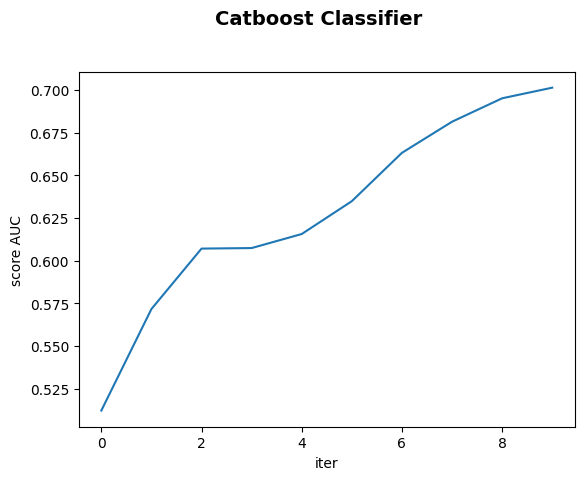

In [26]:
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
fig.suptitle('Catboost Classifier', fontsize=14, fontweight='bold')

ax.set_xlabel('iter')
ax.set_ylabel('score AUC')

ax.plot(df_score_cat_auc['iter'], df_score_cat_auc['score'])

**Метрика Accuracy**

In [27]:
df_score_cat_acc = pd.DataFrame()

df_score_cat_acc['iter'] = [i for i in range(0, len(model_catboost.get_evals_result()['validation']['Accuracy']))]
df_score_cat_acc['score'] = model_catboost.get_evals_result()['validation']['Accuracy']

In [28]:
df_score_cat_acc.head()

,iter,score
0,0,0.964462
1,1,0.964460
2,2,0.964460
3,3,0.964460
4,4,0.964460


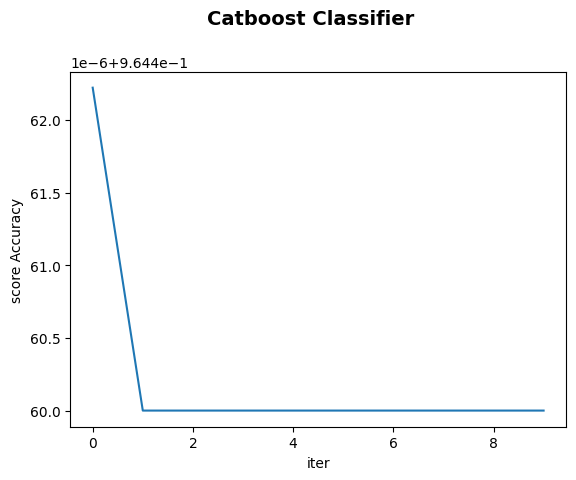

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
fig.suptitle('Catboost Classifier', fontsize=14, fontweight='bold')

ax.set_xlabel('iter')
ax.set_ylabel('score Accuracy')

ax.plot(df_score_cat_acc['iter'], df_score_cat_acc['score'])

Данная метрика не подходит для нашей выборки, так как в выборке дисбаланс классов, поэтому значение метрики остается константным при увеличиении кол-ва итераций.

### Feature importance

In [19]:
df_cat_feature_imp = model_catboost.get_feature_importance(prettified=True)

In [20]:
df_cat_feature_imp

,Feature Id,Importances
0,enc_paym_6_0,11.667673
1,enc_paym_2_0,10.347419
2,enc_paym_19_0,9.181842
3,pre_till_pclose_10,8.969032
4,is_zero_loans3060_0,8.541603
...,...,...
415,pre_loans3060_4,0.000000
416,pre_loans6090_0,0.000000
417,pre_loans3060_3,0.000000
418,pre_loans_total_overdue_1,0.000000


Визуализируем:

In [73]:
 def plot_feature_importance(importance,names,model_type):
        feature_importance = np.array(importance)
        feature_names = np.array(names)
        
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        
        fi_df = pd.DataFrame(data)
        
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
        fi_df = fi_df[:60]
        
        plt.figure(figsize=(10,8))
        
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')

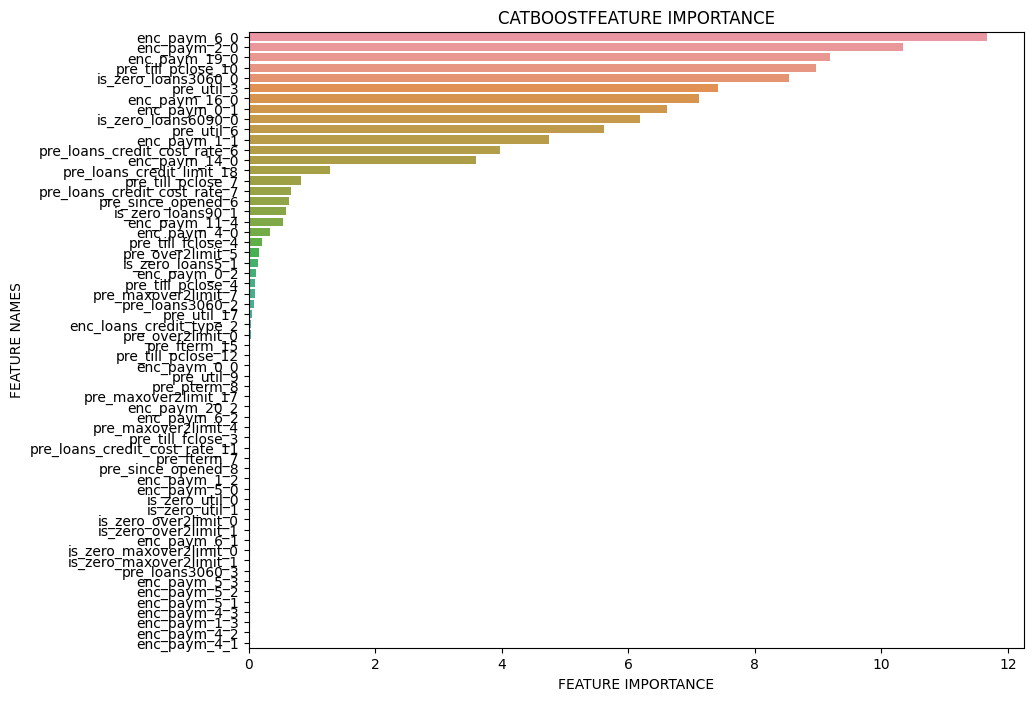

In [74]:
plot_feature_importance(model_catboost.get_feature_importance(),X_train.columns,'CATBOOST')

В CatBoost важность категориальных фичей рассчитывается на основе количества раз, когда данная фича была использована для побдора дерева в модели. Чем чаще категориальная фича используется при построении решающих правил в дереве, тем более значимой она является для модели. 

При расчете важности категориальных фич также учитывается их внутренняя структура. Например, если категориальная фича состоит из подкатегорий, то важность каждой подкатегории рассчитывается отдельно, и важность самой фичи вычисляется как сумма важностей ее подкатегорий.


In [75]:
df_cat_feature_imp.loc[df_cat_feature_imp['Importances'] == 0]

,Feature Id,Importances
43,id,0.0
44,pre_since_opened_0,0.0
45,pre_since_opened_1,0.0
46,pre_since_opened_2,0.0
47,pre_since_opened_3,0.0
...,...,...
415,pre_loans3060_4,0.0
416,pre_loans6090_0,0.0
417,pre_loans3060_3,0.0
418,pre_loans_total_overdue_1,0.0


In [76]:
list(df_cat_feature_imp.loc[df_cat_feature_imp['Importances'] == 0]['Feature Id'])

['id',
 'pre_since_opened_0',
 'pre_since_opened_1',
 'pre_since_opened_2',
 'pre_since_opened_3',
 'pre_since_opened_4',
 'pre_since_opened_5',
 'pre_since_opened_7',
 'pre_since_opened_9',
 'pre_since_opened_10',
 'pre_since_opened_11',
 'pre_since_opened_12',
 'pre_since_opened_13',
 'pre_since_opened_14',
 'pre_since_opened_15',
 'pre_since_opened_16',
 'pre_since_opened_17',
 'pre_since_opened_18',
 'pre_since_opened_19',
 'pre_since_confirmed_0',
 'pre_since_confirmed_1',
 'pre_since_confirmed_2',
 'pre_since_confirmed_3',
 'pre_since_confirmed_4',
 'pre_since_confirmed_5',
 'pre_since_confirmed_6',
 'pre_since_confirmed_7',
 'pre_since_confirmed_8',
 'pre_since_confirmed_9',
 'pre_since_confirmed_10',
 'pre_since_confirmed_11',
 'pre_since_confirmed_12',
 'pre_since_confirmed_13',
 'pre_since_confirmed_14',
 'pre_since_confirmed_16',
 'pre_since_confirmed_17',
 'pre_pterm_0',
 'pre_pterm_1',
 'pre_pterm_2',
 'pre_pterm_3',
 'pre_pterm_4',
 'pre_pterm_5',
 'pre_pterm_6',
 'pre_pt

In [21]:
X_train_new = X_train.drop(list(df_cat_feature_imp.loc[df_cat_feature_imp['Importances'] == 0]['Feature Id']), 
                           axis = 1)

In [22]:
X_train_new

,pre_since_opened_6,pre_since_opened_8,pre_pterm_8,pre_fterm_7,pre_fterm_15,pre_till_pclose_4,pre_till_pclose_7,pre_till_pclose_10,pre_till_pclose_12,pre_till_fclose_3,...,enc_paym_2_0,enc_paym_4_0,enc_paym_6_0,enc_paym_6_2,enc_paym_11_4,enc_paym_14_0,enc_paym_16_0,enc_paym_19_0,enc_paym_20_2,enc_loans_credit_type_2
2870337,1,0,0,1,0,2,0,1,2,0,...,15,15,15,0,6,10,11,9,0,0
1028597,0,0,0,0,0,0,0,0,1,0,...,3,2,1,0,2,1,1,0,0,0
2128397,1,0,0,0,1,0,0,0,0,0,...,4,4,4,0,1,3,2,2,0,0
2511050,0,0,0,0,0,0,0,0,0,0,...,3,3,3,0,1,2,2,2,0,1
2969480,1,0,0,2,1,0,0,2,0,0,...,14,12,11,0,11,5,4,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,0,0,1,1,1,0,0,1,0,0,...,8,7,4,0,7,3,2,2,0,0
2356330,0,1,0,2,1,1,0,3,1,0,...,12,11,10,0,8,6,6,6,1,0
2229084,0,0,0,0,0,0,0,2,0,0,...,3,2,2,0,5,0,0,0,0,0
2768307,0,0,1,4,1,0,1,1,3,2,...,16,13,11,0,7,5,5,7,2,2


In [79]:
X_test_new = X_test.drop(list(df_cat_feature_imp.loc[df_cat_feature_imp['Importances'] == 0]['Feature Id']), 
                         axis = 1)

In [80]:
X_test_new

,pre_since_opened_6,pre_since_opened_8,pre_pterm_8,pre_fterm_7,pre_fterm_15,pre_till_pclose_4,pre_till_pclose_7,pre_till_pclose_10,pre_till_pclose_12,pre_till_fclose_3,...,enc_paym_2_0,enc_paym_4_0,enc_paym_6_0,enc_paym_6_2,enc_paym_11_4,enc_paym_14_0,enc_paym_16_0,enc_paym_19_0,enc_paym_20_2,enc_loans_credit_type_2
2945667,3,1,1,2,0,0,0,2,1,1,...,7,6,7,0,4,6,6,5,0,1
2352586,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
1531260,0,0,0,0,0,0,1,0,3,0,...,7,6,5,0,5,4,3,2,0,0
941910,0,0,0,0,0,0,0,0,1,0,...,3,3,2,0,3,2,2,2,0,0
2582125,1,2,1,0,0,1,0,0,1,0,...,3,2,2,0,3,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186028,0,3,1,1,0,4,0,1,0,1,...,12,11,10,0,13,5,5,4,0,0
2137720,0,0,0,0,0,0,0,0,1,0,...,3,3,3,0,0,3,3,3,0,0
351827,0,0,0,0,0,0,0,0,0,0,...,2,2,1,0,2,1,1,1,0,0
126266,0,0,0,0,0,0,1,0,1,0,...,2,2,2,0,4,0,0,0,0,0


In [81]:
model_catboost_new = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1, 
    eval_metric='AUC', 
#     early_stopping_rounds=5,    
    depth=5,
    random_state=42,
    verbose=1
)

In [82]:
model_catboost_new.fit(
    X_train_new, y_train,
    eval_set=(X_test_new, y_test),
    plot=False
)
print('Model is fitted: ' + str(model_catboost_new.is_fitted()))
print('Model params: ')
print(model_catboost_new.get_params())

0:	test: 0.5324822	best: 0.5324822 (0)	total: 167ms	remaining: 1.51s
1:	test: 0.5566724	best: 0.5566724 (1)	total: 296ms	remaining: 1.18s
2:	test: 0.5882230	best: 0.5882230 (2)	total: 460ms	remaining: 1.07s
3:	test: 0.5885548	best: 0.5885548 (3)	total: 585ms	remaining: 877ms
4:	test: 0.5974145	best: 0.5974145 (4)	total: 733ms	remaining: 733ms
5:	test: 0.6497105	best: 0.6497105 (5)	total: 878ms	remaining: 586ms
6:	test: 0.6785022	best: 0.6785022 (6)	total: 1.02s	remaining: 438ms
7:	test: 0.6929712	best: 0.6929712 (7)	total: 1.18s	remaining: 294ms
8:	test: 0.6977968	best: 0.6977968 (8)	total: 1.33s	remaining: 148ms
9:	test: 0.7018628	best: 0.7018628 (9)	total: 1.48s	remaining: 0us

bestTest = 0.7018628268
bestIteration = 9

Model is fitted: True
Model params: 
{'iterations': 10, 'learning_rate': 0.1, 'depth': 5, 'verbose': 1, 'custom_metric': ['AUC', 'Accuracy'], 'eval_metric': 'AUC', 'random_state': 42}


In [83]:
print("Best Score: \n", model_catboost_new.get_best_score())

Best Score: 
 {'learn': {'Logloss': 0.18088616391754575}, 'validation': {'Logloss': 0.18114020570722128, 'AUC': 0.7018628267961526}}


### GridSearchCV

In [43]:
model_catboost_gs = CatBoostClassifier(
    eval_metric='AUC:hints=skip_train~false',
    verbose=50,
    early_stopping_rounds=500
)

In [46]:
params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.001, 0.01, 0.1],
    'depth': [5, 6]
}

In [47]:
model_catboost_gs.grid_search(params, X_train_new, y_train, cv=3)

0:	learn: 0.5415813	test: 0.5433880	best: 0.5433880 (0)	total: 197ms	remaining: 1m 38s
50:	learn: 0.6695752	test: 0.6728579	best: 0.6818616 (42)	total: 7.56s	remaining: 1m 6s
100:	learn: 0.6657028	test: 0.6677438	best: 0.6818616 (42)	total: 15.4s	remaining: 1m
150:	learn: 0.6724953	test: 0.6744086	best: 0.6818616 (42)	total: 23.4s	remaining: 54.1s
200:	learn: 0.6736646	test: 0.6756649	best: 0.6818616 (42)	total: 31.2s	remaining: 46.5s
250:	learn: 0.6749654	test: 0.6770853	best: 0.6818616 (42)	total: 39.1s	remaining: 38.8s
300:	learn: 0.6769619	test: 0.6791110	best: 0.6818616 (42)	total: 46.9s	remaining: 31s
350:	learn: 0.6815739	test: 0.6836630	best: 0.6837493 (348)	total: 54.7s	remaining: 23.2s
400:	learn: 0.6839042	test: 0.6859161	best: 0.6864858 (390)	total: 1m 2s	remaining: 15.5s
450:	learn: 0.6887088	test: 0.6905821	best: 0.6908301 (449)	total: 1m 11s	remaining: 7.72s
499:	learn: 0.6907651	test: 0.6924851	best: 0.6925061 (498)	total: 1m 19s	remaining: 0us

bestTest = 0.6925060825


500:	learn: 0.7340760	test: 0.7335789	best: 0.7335789 (500)	total: 1m 25s	remaining: 1m 25s
550:	learn: 0.7345528	test: 0.7337065	best: 0.7337065 (550)	total: 1m 33s	remaining: 1m 16s
600:	learn: 0.7350201	test: 0.7337509	best: 0.7337634 (592)	total: 1m 42s	remaining: 1m 7s
650:	learn: 0.7355382	test: 0.7338395	best: 0.7338395 (650)	total: 1m 50s	remaining: 59.3s
700:	learn: 0.7359449	test: 0.7338661	best: 0.7338855 (689)	total: 1m 59s	remaining: 50.8s
750:	learn: 0.7363740	test: 0.7339749	best: 0.7339749 (750)	total: 2m 7s	remaining: 42.2s
800:	learn: 0.7367209	test: 0.7339955	best: 0.7340135 (789)	total: 2m 15s	remaining: 33.7s
850:	learn: 0.7371133	test: 0.7340801	best: 0.7340819 (847)	total: 2m 23s	remaining: 25.2s
900:	learn: 0.7376043	test: 0.7341385	best: 0.7341524 (896)	total: 2m 32s	remaining: 16.7s
950:	learn: 0.7379696	test: 0.7341454	best: 0.7341623 (940)	total: 2m 40s	remaining: 8.29s
999:	learn: 0.7383647	test: 0.7341632	best: 0.7341711 (996)	total: 2m 49s	remaining: 0us


999:	learn: 0.7286405	test: 0.7305085	best: 0.7305085 (999)	total: 2m 59s	remaining: 0us

bestTest = 0.730508512
bestIteration = 999

10:	loss: 0.7305085	best: 0.7342126 (8)	total: 22m 44s	remaining: 2m 4s
0:	learn: 0.5422281	test: 0.5440024	best: 0.5440024 (0)	total: 192ms	remaining: 3m 11s
50:	learn: 0.7239327	test: 0.7261890	best: 0.7261890 (50)	total: 9.27s	remaining: 2m 52s
100:	learn: 0.7286024	test: 0.7302631	best: 0.7302631 (100)	total: 18.4s	remaining: 2m 43s
150:	learn: 0.7306683	test: 0.7317341	best: 0.7317341 (150)	total: 27.2s	remaining: 2m 32s
200:	learn: 0.7320784	test: 0.7324569	best: 0.7324569 (200)	total: 35.9s	remaining: 2m 22s
250:	learn: 0.7332044	test: 0.7328813	best: 0.7328813 (250)	total: 44.7s	remaining: 2m 13s
300:	learn: 0.7341412	test: 0.7332599	best: 0.7332599 (300)	total: 53.3s	remaining: 2m 3s
350:	learn: 0.7350018	test: 0.7335722	best: 0.7335722 (350)	total: 1m 1s	remaining: 1m 54s
400:	learn: 0.7358333	test: 0.7338441	best: 0.7338448 (395)	total: 1m 10s

{'params': {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [48]:
print("Best score:", end=' ')
print(model_catboost_gs.best_score_)
print("Best params:", end=' ')
print(model_catboost_gs.get_params())

Best score: {'learn': {'Logloss': 0.138455538107514, 'AUC': 0.7421425157258901}}
Best params: {'verbose': 50, 'eval_metric': 'AUC:hints=skip_train~false', 'early_stopping_rounds': 500, 'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}


### Финальная модель

In [30]:
from catboost import cv

In [49]:
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 1000
params['learning_rate'] = 0.1 
params['early_stopping_rounds'] = 50
params['eval_metric']='AUC'
params['depth'] = 6

In [50]:
cv_data = cv(
    params = params,
    pool=Pool(X, label=y),
    fold_count=3,
    inverted=False,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=True,
    verbose=50
)

Training on fold [0/3]
0:	test: 0.5473340	best: 0.5473340 (0)	total: 634ms	remaining: 10m 33s
50:	test: 0.7406427	best: 0.7406427 (50)	total: 30.5s	remaining: 9m 28s
100:	test: 0.7489661	best: 0.7489661 (100)	total: 1m 1s	remaining: 9m 9s
150:	test: 0.7524085	best: 0.7524085 (150)	total: 1m 33s	remaining: 8m 46s
200:	test: 0.7542460	best: 0.7542460 (200)	total: 2m 3s	remaining: 8m 12s
250:	test: 0.7557282	best: 0.7557295 (249)	total: 2m 34s	remaining: 7m 41s
300:	test: 0.7567987	best: 0.7567987 (300)	total: 3m 5s	remaining: 7m 10s
350:	test: 0.7576483	best: 0.7576483 (350)	total: 3m 38s	remaining: 6m 44s
400:	test: 0.7581841	best: 0.7581841 (400)	total: 4m 9s	remaining: 6m 12s
450:	test: 0.7586588	best: 0.7586640 (448)	total: 4m 42s	remaining: 5m 44s
500:	test: 0.7591860	best: 0.7591860 (500)	total: 5m 14s	remaining: 5m 12s
550:	test: 0.7594903	best: 0.7594903 (550)	total: 5m 45s	remaining: 4m 41s
600:	test: 0.7597483	best: 0.7597503 (593)	total: 6m 16s	remaining: 4m 9s
650:	test: 0.76

In [52]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.518642,0.024869,0.552976,0.000397,0.552899,0.000388
1,1,0.543219,0.030587,0.449374,0.000788,0.449369,0.000774
2,2,0.551014,0.025186,0.373460,0.000642,0.373474,0.000630
3,3,0.586322,0.040491,0.316970,0.001507,0.316957,0.001496
4,4,0.599808,0.039560,0.276069,0.001329,0.276029,0.001323
...,...,...,...,...,...,...,...
995,995,0.761978,0.000784,0.137347,0.000103,0.133821,0.000048
996,996,0.761982,0.000780,0.137346,0.000103,0.133818,0.000048
997,997,0.761982,0.000778,0.137346,0.000102,0.133815,0.000049
998,998,0.761982,0.000779,0.137346,0.000103,0.133812,0.000050


In [56]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])


In [61]:
print('Best validation AUC score, stratified:')
print('Best score:', best_value)
print('Best iter:', best_iter)

Best validation AUC score, stratified:
Best score: 0.7619892966446415
Best iter: 999
